In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import datetime as dt
from Monte_Carlo_utils import *
import yfinance as yf
from scipy.stats import uniform_direction

Import Data

In [2]:
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)
historic, returns = get_data(stocks, startDate, endDate)
meanReturns, covMatrix = get_statistics(returns)

[*********************100%%**********************]  6 of 6 completed


Generate a random portfolio.

In [3]:
weights = uniform_direction.rvs(len(stockList))
print("Portfolio Weights are {}.\nThe modulus of this vector is {}.".format(weights, np.linalg.norm(weights)))

Portfolio Weights are [-0.19878112 -0.15781385 -0.71988452 -0.24074432 -0.52394378 -0.29132836].
The modulus of this vector is 0.9999999999999999.


Monte Carlo Simulation. This is the code used in the function Monte_Carlo_utils. MC_Simulation

In [4]:
#number of simulatios
n_sims = 100000
#maturity (days)
T = 100
D = len(stockList)

In [5]:
Z = np.random.normal(size=(T, len(stockList), n_sims))
L = np.linalg.cholesky(covMatrix)
dailyReturns = np.expand_dims(meanReturns, axis=[0, 2]) + L @ Z
portfolio_simulation = np.cumprod((weights @ dailyReturns) + 1, axis=0)

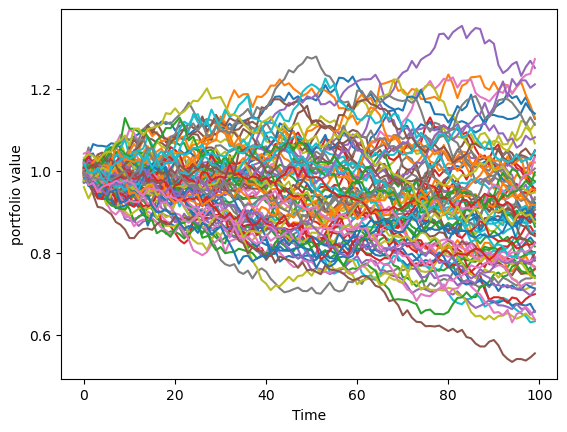

In [6]:
plt.plot(portfolio_simulation[:, :80])
plt.xlabel('Time')
plt.ylabel('portfolio value')
plt.show()

In [7]:
mcmean = dailyReturns.mean(axis=0).mean(axis=1)
print(mcmean)
print(meanReturns)
print(mcmean - meanReturns)

[ 0.000593    0.00085697  0.00057035  0.00064985 -0.00023913  0.000511  ]
Close  BHP.AX    0.000593
       CBA.AX    0.000853
       NAB.AX    0.000565
       STO.AX    0.000644
       TLS.AX   -0.000243
       WBC.AX    0.000505
dtype: float64
Close  BHP.AX    2.320339e-07
       CBA.AX    3.918009e-06
       NAB.AX    4.958009e-06
       STO.AX    6.211214e-06
       TLS.AX    3.546926e-06
       WBC.AX    6.128866e-06
dtype: float64


In [8]:
simcov = np.cov(dailyReturns[0, :, :])
covMatrix - simcov

Close                                            \
                    BHP.AX        CBA.AX        NAB.AX        STO.AX   
Close BHP.AX  6.173699e-07  5.453166e-07  6.277760e-07  4.426818e-07   
      CBA.AX  5.453166e-07 -1.051292e-08 -2.035642e-07 -1.519019e-07   
      NAB.AX  6.277760e-07 -2.035642e-07 -4.064353e-07 -1.777836e-08   
      STO.AX  4.426818e-07 -1.519019e-07 -1.777836e-08 -3.291386e-08   
      TLS.AX -1.966992e-07  2.928453e-07 -2.045484e-07 -1.804221e-07   
      WBC.AX  1.183638e-06  6.399537e-08 -5.859614e-07  2.896037e-07   

                                          
                    TLS.AX        WBC.AX  
Close BHP.AX -1.966992e-07  1.183638e-06  
      CBA.AX  2.928453e-07  6.399537e-08  
      NAB.AX -2.045484e-07 -5.859614e-07  
      STO.AX -1.804221e-07  2.896037e-07  
      TLS.AX  4.200733e-07 -1.049588e-07  
      WBC.AX -1.049588e-07  3.143070e-07

Calculating VaR

In [9]:
def MC_VaR(returns, alpha=0.01):
    VaR = np.quantile(returns, alpha)
    CVaR = np.mean(returns[returns<=VaR])

    return VaR, CVaR

In [10]:
VaR, CVaR = MC_VaR(portfolio_simulation[-1,:], alpha = 0.05)
print(VaR, CVaR)

0.6999186248380471 0.6566690649890363


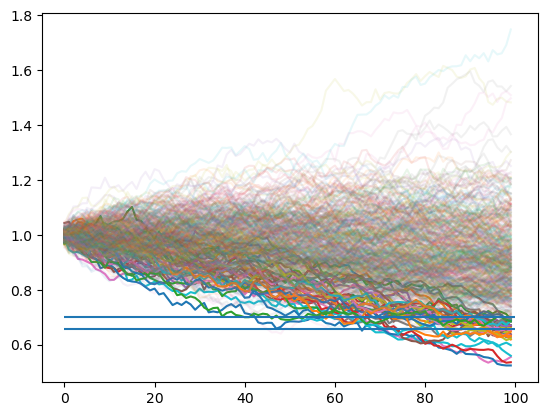

In [11]:
nplot = 500
plotted = portfolio_simulation[:, :nplot]
mask = (plotted[-1,:]<VaR)
highalpha = plotted[np.full((T, nplot), fill_value=mask)].reshape(T,-1)
lowalpha = plotted[np.full((T, nplot), fill_value=np.logical_not(mask))].reshape(T,-1)
plt.plot(highalpha)
plt.plot(lowalpha, alpha = 0.1)
plt.hlines(y=[VaR, CVaR], xmin=0, xmax=T)
plt.show()